In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pdb
from scipy.optimize import curve_fit
import astropy.units as u
import astropy.constants as const
from scipy.integrate import quad
%matplotlib inline

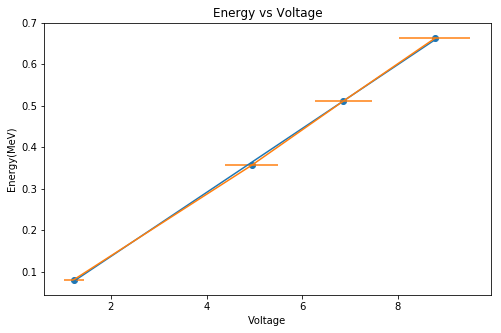

In [3]:
# lets read in 0deg,1
y = np.array([0.081,0.356,0.511,0.662])
x = np.array([1.23, 4.94, 6.86, 8.77])
y_unc = np.array([0.2,0.56,0.59,0.74])

fit_m, fit_b = np.polyfit(x,y,1)

def V_to_E_fit(x):
    new_y = fit_m * x + fit_b
    return new_y

new_y = V_to_E_fit(x)

fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,5)
ax.plot(x,new_y)
ax.scatter(x,y)
ax.errorbar(x,y,xerr=y_unc)
ax.set(xlabel='Voltage', ylabel="Energy(MeV)", title="Energy vs Voltage")
fig.savefig("volt_energy.png")

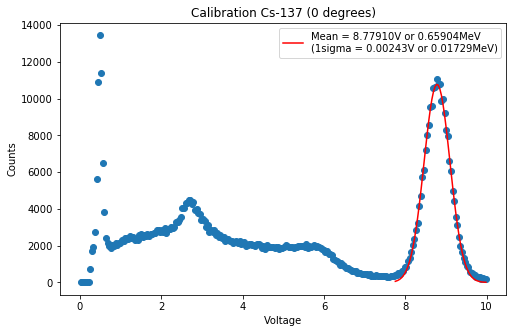

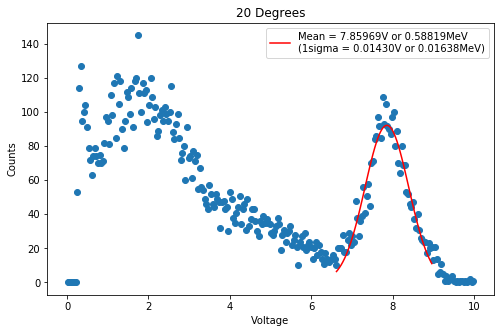

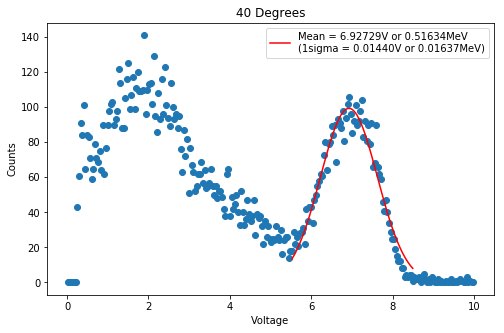

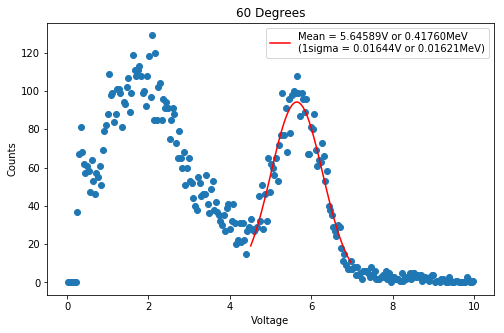

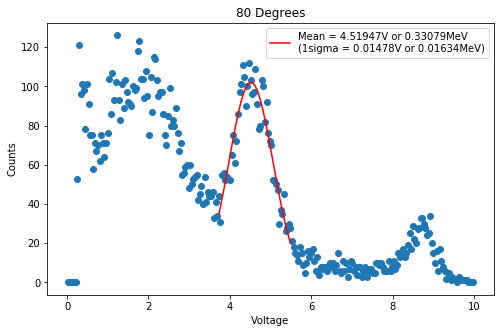

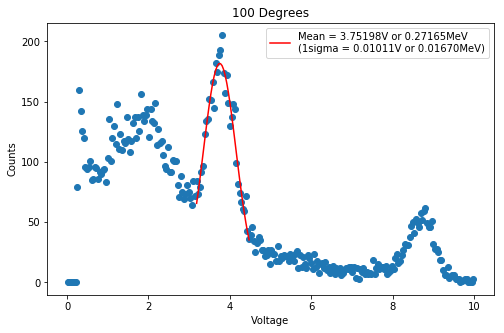

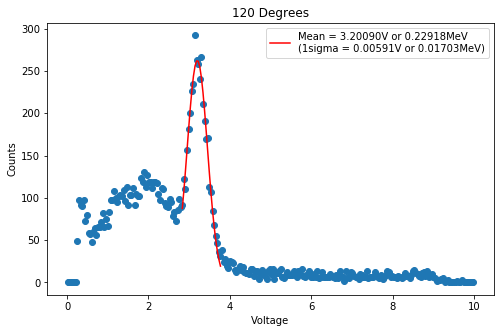

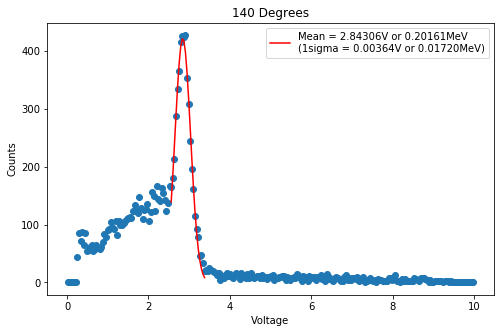

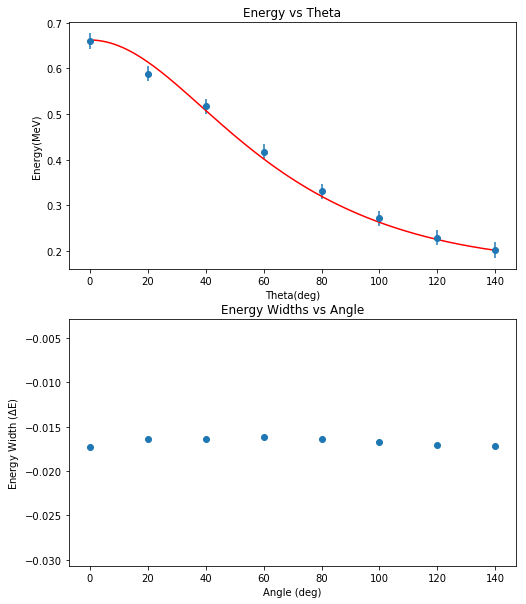

In [4]:
# lets organize all the data files
lab6_dir_content = os.listdir("./")
deg_files = np.array([])
slab_files = np.array([])
for file in lab6_dir_content:
    if file.find("txt") != -1: # is a data file
        if file.find("slab") != -1: # is a slab data file
            slab_files = np.append(slab_files, file)
        elif (file.find("cs137") != -1):
            deg_files = np.append(deg_files, file)
            
            
density = 1.18 * u.g/(u.cm**3)
atom_mass = 100.1158 * u.g/u.mol
electron_density = const.N_A * density / atom_mass
#pdb.set_trace()
def gaus(x,a,b,c):
    return a * np.exp(-((x-b)**2)/(2*c**2))

def wavelen_to_energy(wavelen):
    energy = const.c * const.h / wavelen
    return energy

def energy_to_wavelen(energy):
    wavelen = const.h * const.c / energy
    return wavelen

def compton(theta, lam):
    theta = theta * u.deg
    new_lam = const.h / (const.m_e * const.c) * (1 - np.cos(theta)) + lam
    return new_lam.decompose()
    
def degree_analysis(deg_file_list):
    '''
    here, we will input the file list containing all the degree data files
    '''
    # lets define a list of upper and lower bounds for each set of data
    # idx 0 = calib
    lower_bound = np.array([7.75,6.6,5.5,4.5,3.7,3.15,2.8,2.55])
    upper_bound = np.array([10,9,8.5,7,5.5,4.5,3.8,3.4])
    asc_deg_list = np.array([0,20,40,60,80,100,120,140])
    energy_list = np.array([])
    energy_err_list = np.array([])
    
    # lets start with calib
    for idx,file in enumerate(deg_file_list):
        if file.find("calib") != -1:
            calib_file = file
            deg_file_list = np.delete(deg_file_list,idx)
    calib_data = np.loadtxt(calib_file)
    peak_volt = calib_data[:,0] # x
    counts = calib_data[:,1] # y 
    
    # we want to define a x_range in which to fit a gaussian
    # calib 8 to 10
    desired_peak_mask = np.where((calib_data[:,0] > lower_bound[0])&(calib_data[:,0]<upper_bound[0]))
    desired_peak = calib_data[desired_peak_mask]
    x = desired_peak[:,0]
    y = desired_peak[:,1]
    popt,pcov = curve_fit(gaus,x,y,p0=[1,8.76,1])
    perr = np.sqrt(np.diag(pcov))
    a_err, b_err, c_err = perr
    a, b, c = popt
    y_fit = gaus(x,a,b,c)
    energy_list = np.append(energy_list, b)
    energy_err_list = np.append(energy_err_list, b_err)
    
    # lets get lambda; b is an energy
    cs137_energy = 0.662 * u.MeV
    cs137_wavelen = energy_to_wavelen(cs137_energy)
    
    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(8,5)
    ax.scatter(peak_volt,counts)
    label="Mean = %0.5fV or %0.5fMeV\n(1sigma = %0.5fV or %0.5fMeV)"%(b,V_to_E_fit(b),b_err,abs(V_to_E_fit(b_err)))
    ax.plot(desired_peak[:,0],y_fit,color='r', label=label)
    ax.set(title="Calibration Cs-137 (0 degrees)",xlabel="Voltage",ylabel="Counts")
    ax.legend(loc=0)
    fig.savefig("0_deg.png")
    
    # lets sort the deg_files list so its in ascending order
    sorted_deg_list = np.array([])
    for d in asc_deg_list[1:]:
        for file in deg_file_list:
            file_name = file
            file = file.split("deg.txt")
            file = file[0].split("cs137_")
            deg = int(file[1])
            if deg == d:
                sorted_deg_list = np.append(sorted_deg_list, file_name)
    

    for idx,file in enumerate(sorted_deg_list):
        file_name = file
        file = file.split("deg.txt")

        file = file[0].split("cs137_")
        deg = int(file[1])
        data = np.loadtxt(file_name)
        volts = data[:,0]
        counts = data[:,1]
        
        # quick plot
        fig,ax = plt.subplots(1,1)
        fig.set_size_inches(8,5)
        ax.scatter(volts, counts)
        ax.set(title=str(deg)+" Degrees")
        
        # now lets get the desired peak
        peak_lower = lower_bound[idx+1]
        peak_upper = upper_bound[idx+1]
                         
        desired_peak_mask = np.where((data[:,0] > peak_lower)&(data[:,0]<peak_upper))
        desired_peak = data[desired_peak_mask]
        x = desired_peak[:,0]
        y = desired_peak[:,1]
        mean_estimate = x[np.argmax(y)]
        popt, pcov = curve_fit(gaus, x, y, p0=[1,mean_estimate,1])
        a, b, c = popt
        perr = np.sqrt(np.diag(pcov))
        a_err, b_err, c_err = perr
        energy_list = np.append(energy_list, b)
        energy_err_list = np.append(energy_err_list, b_err)
        label="Mean = %0.5fV or %0.5fMeV\n(1sigma = %0.5fV or %0.5fMeV)"%(b,V_to_E_fit(b),b_err,abs(V_to_E_fit(b_err)))
        y_fit = gaus(x,a,b,c)
        ax.plot(x,y_fit,color='r',label=label)
        ax.set(xlabel="Voltage",ylabel="Counts")
        ax.legend(loc=0)
        fig.savefig("%i_deg.png"%deg)
        
    
    # now to plot energy vs theta
    x_compt = np.linspace(0,140,1000)
    y_compt = compton(x_compt,cs137_wavelen)
    y_compt = wavelen_to_energy(y_compt)
    y_compt = y_compt.to(u.MeV)
    
    fig,ax = plt.subplots(2,1)
    fig.set_size_inches(8,10)
    ax[0].errorbar(asc_deg_list,V_to_E_fit(energy_list),yerr=V_to_E_fit(energy_err_list),fmt='o')
    ax[0].plot(x_compt, y_compt,color='r')
    ax[0].set(title="Energy vs Theta", xlabel="Theta(deg)",ylabel="Energy(MeV)")
    
    ax[1].scatter(asc_deg_list,V_to_E_fit(energy_err_list))
    ax[1].set(title='Energy Widths vs Angle', xlabel='Angle (deg)', ylabel='Energy Width ($\Delta$E)')
    fig.savefig("dem_curves.png")

degree_analysis(deg_files)         

        

In [5]:
(const.h/(const.m_e * const.c)).decompose()

<Quantity 2.426310237119079e-12 m>

2.41386057023e-25


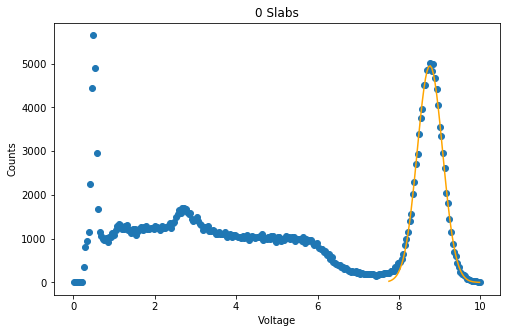

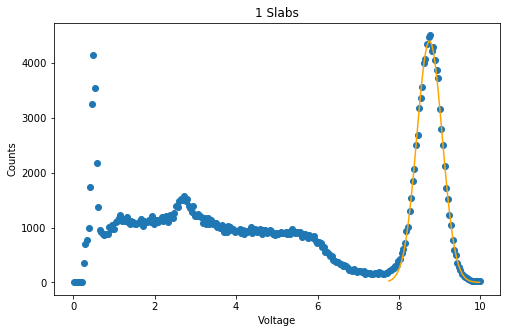

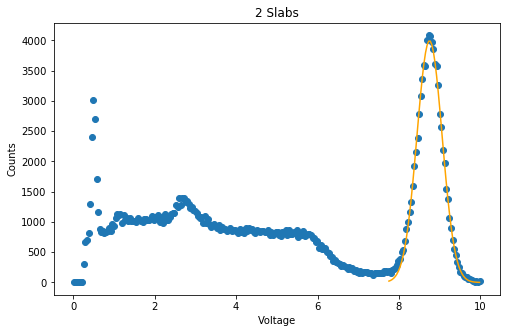

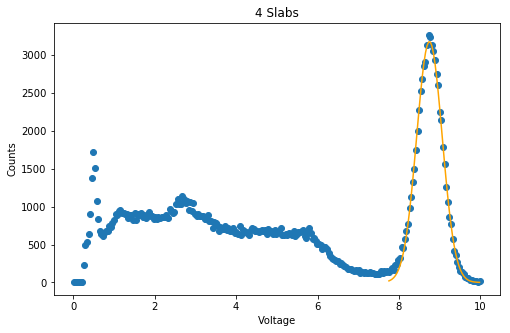

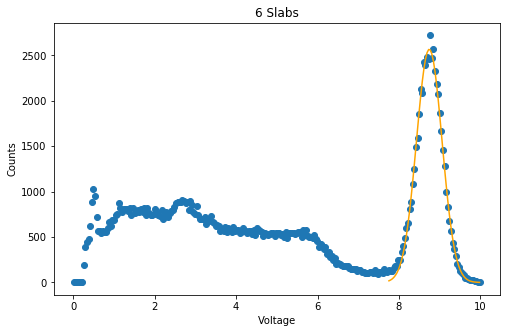

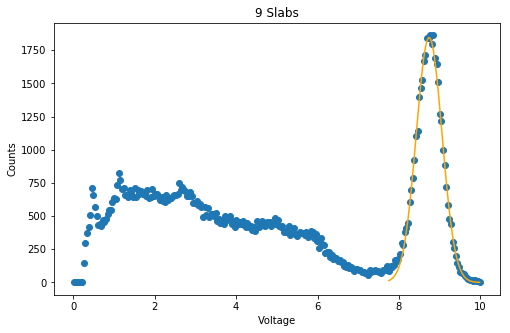

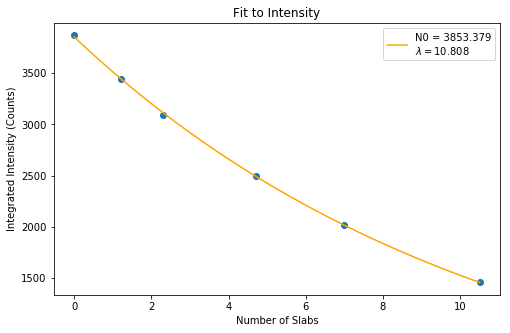

In [16]:
atom_mass = 100.1158*u.g/u.mol
density = 1.18 * u.g / (u.cm**3)
n_atoms = const.N_A * density / atom_mass
n_e_per_atom = 6*5 + 8*2 + 1*8
n_e_density = (n_atoms * n_e_per_atom).value

def exp_counts(nslabs, counts0, lam):
    # this is a function we will fit to get lambda. 
    counts = counts0 * np.exp(-nslabs/lam)
    return counts

def slab_analysis():
    dir_list = os.listdir('./')
    slab_file_list = np.array([])
    num_slabs = np.array([0,1,2,4,6,9])
    slabs_thickness = np.array([0,1.2,2.3,4.7,7.0,10.5])
    N_interactions = np.array([])
    lower_bounds = 7.75
    upper_bounds = 10
    for file in dir_list:
        if file.find('slab') != -1:
            slab_file_list = np.append(slab_file_list, file)
    for num in num_slabs:
        for file in slab_file_list:
            if file[-11:].find(str(num)) != -1: # we are doing these in ascending order
                data = np.loadtxt(file)
                desired_mask = np.where((data[:,0] > lower_bounds) & (data[:,0] < upper_bounds))
                desired_data = data[desired_mask]
                x = desired_data[:,0]
                y = desired_data[:,1]
                mean_estimate = x[np.argmax(y)]
                popt, pcov = curve_fit(gaus, x, y, p0=[1,mean_estimate,1])
                a, b, c = popt
                perr = np.sqrt(np.diag(pcov))
                a_err, b_err, c_err = perr
                y_fit = gaus(x,a,b,c)
                y_fit_integrated = quad(gaus,lower_bounds,upper_bounds,args=(a,b,c))
                N_interactions = np.append(N_interactions, y_fit_integrated[0])

                fig,ax = plt.subplots(1,1)
                fig.set_size_inches(8,5)
                ax.scatter(data[:,0],data[:,1])
                ax.plot(x,y_fit,color='orange')
                ax.set(title=str(num) + ' Slabs', xlabel='Voltage', ylabel='Counts')
    
    popt, pcov = curve_fit(exp_counts, slabs_thickness, N_interactions, p0=[N_interactions[0],1])
    counts0, lam = popt
    counts0_err, lam_err = pcov
    x_fit = np.linspace(slabs_thickness[0],slabs_thickness[-1],1000)
    y_fit = exp_counts(x_fit, counts0, lam)
    fit_label = "N0 = %0.3f\n$\lambda = %0.3f$"%(counts0, lam)
    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(8,5)
    ax.scatter(slabs_thickness, N_interactions)
    ax.plot(x_fit, y_fit, color='orange', label=fit_label)
    ax.set(xlabel="Slab Thickness (cm)", ylabel='Integrated Intensity (Counts)', title='Fit to Intensity')
    ax.legend(loc=0)
    compton_scattering_crossection = 1/(n_e_density * lam)
    print(compton_scattering_crossection)
        

slab_analysis()

3.5092105263157887